# Notebook 02: Spatial Clustering Demo (K-Means & DBSCAN)

This notebook explores two common clustering algorithms, K-Means and DBSCAN, applied to synthetic spatial point data. Clustering is a fundamental unsupervised machine learning technique used to group similar data points together. In a spatial context, this can help identify hotspots, define regions of similar characteristics, or preprocess data for other spatial analyses.

**Objectives:**
- Generate synthetic spatial point data with varying cluster shapes, densities, and some noise.
- Apply K-Means clustering, discuss its parameters, strengths, and weaknesses in a spatial context.
- Apply DBSCAN clustering, discuss its parameters, strengths, and weaknesses, particularly its ability to find arbitrarily shaped clusters and identify noise.
- Visualize and compare the results of both algorithms on the same dataset.

**Libraries Used:**
- `numpy` for numerical operations and data generation.
- `pandas` for data manipulation.
- `geopandas` for handling spatial data.
- `shapely` for geometric objects.
- `scikit-learn` for clustering algorithms (KMeans, DBSCAN) and data scaling.
- `matplotlib` and `seaborn` for plotting.
- `contextily` for adding basemaps (optional).


## 1. Setup: Imports and Configuration

First, we import the necessary libraries and define some configuration parameters for our synthetic data generation and plotting.


In [1]:
#%%
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler  # For DBSCAN, scaling can be important
from sklearn.neighbors import NearestNeighbors  # For helping to choose DBSCAN's eps
import contextily as ctx
import warnings

# Plotting style
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams['figure.figsize'] = (10, 8)  # Adjusted default figure size
warnings.filterwarnings("ignore", category=UserWarning, module="contextily")
warnings.filterwarnings("ignore", category=FutureWarning)  # Ignore some sklearn warnings for n_init

# --- Configuration for Synthetic Data ---
# Using similar bounds as the site optimization notebook for consistency
MIN_X, MAX_X = 100000, 400000
MIN_Y, MAX_Y = 0, 200000
REGION_CRS = "EPSG:27700"  # British National Grid (units in meters)

N_POINTS_TOTAL = 500  # Total number of points to generate for clustering

# Helper function to create GeoDataFrame (reused from previous notebook)
def create_gdf_from_points(x_coords, y_coords, crs, attributes=None):
    """Creates a GeoDataFrame from X and Y coordinates with optional attributes."""
    geometry = [Point(x, y) for x, y in zip(x_coords, y_coords)]
    gdf = gpd.GeoDataFrame(geometry=geometry, crs=crs)
    if attributes:
        for col_name, values in attributes.items():
            gdf[col_name] = values
    return gdf

# Helper function for plotting clustering results
def plot_clusters(gdf, cluster_labels_col, title, ax=None, show_noise=True, palette='viridis', region_boundary_gdf=None, centroids_gdf=None):
    """Helper function to plot clustering results."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 10))

    unique_labels = gdf[cluster_labels_col].unique()
    n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels and show_noise else 0)  # -1 is often noise for DBSCAN

    # Create a color map
    if isinstance(palette, str):
        colors = plt.cm.get_cmap(palette, len(unique_labels))
    else:  # Assume palette is a list/dict of colors
        colors = palette

    # Plot region boundary if provided
    if region_boundary_gdf is not None:
        region_boundary_gdf.plot(ax=ax, facecolor='gray', alpha=0.1, edgecolor='black', zorder=0)

    # Plot each cluster
    for k_idx, k_label in enumerate(unique_labels):
        cluster_data = gdf[gdf[cluster_labels_col] == k_label]
        
        point_color = colors(k_idx / len(unique_labels)) if isinstance(palette, str) else colors.get(k_label, 'gray')
        marker_style = 'o'
        point_size = 50
        alpha_val = 0.7
        label_text = f'Cluster {k_label}'

        if k_label == -1 and show_noise:  # DBSCAN noise points
            point_color = 'gray'
            marker_style = 'x'
            point_size = 30
            alpha_val = 0.5
            label_text = 'Noise'
        elif k_label == -1 and not show_noise:
            continue  # Skip plotting noise

        cluster_data.plot(ax=ax, marker=marker_style, color=point_color,
                          markersize=point_size, alpha=alpha_val, label=label_text,
                          edgecolor='black', linewidth=0.5)

    # Plot centroids if provided (typically for K-Means)
    if centroids_gdf is not None:
        centroids_gdf.plot(ax=ax, marker='X', color='red', markersize=150, label="Centroids", edgecolor='black', zorder=3)

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    
    # Basemap (optional, as in previous notebook)
    if REGION_CRS == "EPSG:27700":
        ax.set_xlim(MIN_X - 0.05 * (MAX_X - MIN_X), MAX_X + 0.05 * (MAX_X - MIN_X))
        ax.set_ylim(MIN_Y - 0.05 * (MAX_Y - MIN_Y), MAX_Y + 0.05 * (MAX_Y - MIN_Y))
    # try:
    #     ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.CartoDB.PositronOnlyLabels, zorder=1)
    # except Exception as e:
    #     print(f"Note: Basemap could not be added. Error: {e}")

    # Create a legend that doesn't duplicate
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicate labels for legend
    ax.legend(by_label.values(), by_label.keys(), loc="upper right", title="Clusters")
    
    if ax is None:  # Only call tight_layout and show if we created the fig/ax here
        plt.tight_layout()
        plt.show()

# Synthetic region boundary
region_poly = Polygon([(MIN_X, MIN_Y), (MAX_X, MIN_Y), (MAX_X, MAX_Y), (MIN_X, MAX_Y)])
region_gdf_boundary = gpd.GeoDataFrame([{'id': 1, 'geometry': region_poly}], crs=REGION_CRS)

print("Setup complete.")


Setup complete.


## 2. Synthetic Data Generation for Clustering

To effectively demonstrate and compare clustering algorithms, we need synthetic data that presents a few challenges:
- Clusters of different shapes (e.g., spherical, elongated).
- Clusters of different densities.
- Some noise points that don't belong to any clear cluster.

We'll generate points from several distributions and combine them.


Generated 500 synthetic points for clustering.


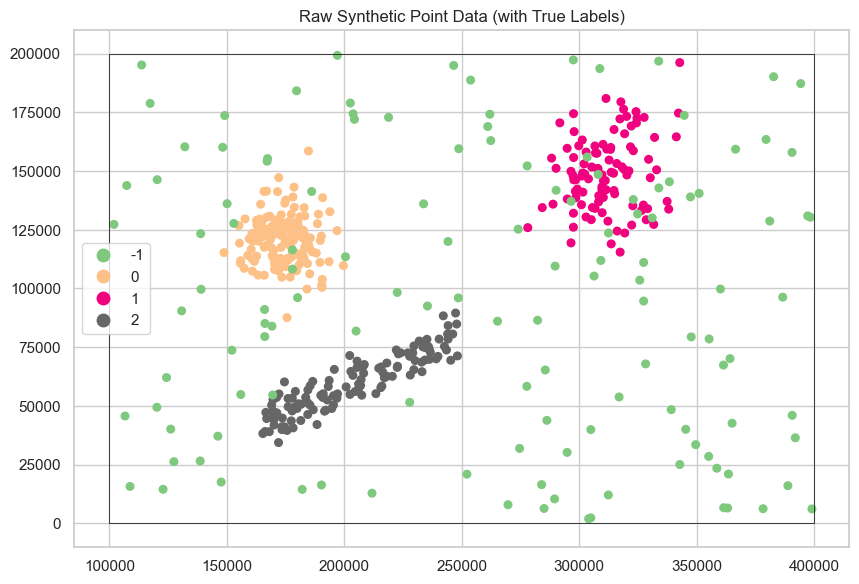

In [2]:
np.random.seed(42)  # For reproducibility

points_list = []  # To store (x, y) tuples

# Cluster 1: Dense, spherical
n1 = 150
center1_x, center1_y = MIN_X + 0.25 * (MAX_X - MIN_X), MIN_Y + 0.6 * (MAX_Y - MIN_Y)
spread1 = (MAX_X - MIN_X) / 30
points_list.extend(zip(np.random.normal(center1_x, spread1, n1),
                       np.random.normal(center1_y, spread1, n1)))

# Cluster 2: Less dense, spherical
n2 = 100
center2_x, center2_y = MIN_X + 0.7 * (MAX_X - MIN_X), MIN_Y + 0.75 * (MAX_Y - MIN_Y)
spread2 = (MAX_X - MIN_X) / 20
points_list.extend(zip(np.random.normal(center2_x, spread2, n2),
                       np.random.normal(center2_y, spread2, n2)))

# Cluster 3: Elongated / non-spherical (e.g., along a line with some spread)
n3 = 120
# Define a line segment
line_start_x, line_start_y = MIN_X + 0.2 * (MAX_X - MIN_X), MIN_Y + 0.2 * (MAX_Y - MIN_Y)
line_end_x, line_end_y = MIN_X + 0.5 * (MAX_X - MIN_X), MIN_Y + 0.4 * (MAX_Y - MIN_Y)
# Generate points along this line with some perpendicular spread
t = np.random.rand(n3)  # Parameter along the line
x_on_line = line_start_x + t * (line_end_x - line_start_x)
y_on_line = line_start_y + t * (line_end_y - line_start_y)
# Add perpendicular noise
angle = np.arctan2(line_end_y - line_start_y, line_end_x - line_start_x)
perp_angle = angle + np.pi / 2
perp_spread = (MAX_X - MIN_X) / 50
offset_x = np.random.normal(0, perp_spread, n3) * np.cos(perp_angle)
offset_y = np.random.normal(0, perp_spread, n3) * np.sin(perp_angle)
points_list.extend(zip(x_on_line + offset_x, y_on_line + offset_y))

# Noise points: Uniformly distributed
n_noise = N_POINTS_TOTAL - (n1 + n2 + n3)
if n_noise < 0:
    n_noise = 30  # Ensure some noise if counts exceed total

points_list.extend(zip(np.random.uniform(MIN_X, MAX_X, n_noise),
                       np.random.uniform(MIN_Y, MAX_Y, n_noise)))

# Create GeoDataFrame
synthetic_points_x = np.array([p[0] for p in points_list])
synthetic_points_y = np.array([p[1] for p in points_list])

# Clip to bounds to be safe
synthetic_points_x = np.clip(synthetic_points_x, MIN_X, MAX_X)
synthetic_points_y = np.clip(synthetic_points_y, MIN_Y, MAX_Y)

# Add true labels for later evaluation (optional, but good for understanding)
true_labels = ([0] * n1) + ([1] * n2) + ([2] * n3) + ([-1] * n_noise)  # -1 for noise
attributes_dict = {'true_label': true_labels[:len(synthetic_points_x)]}  # Ensure labels match point count

points_gdf = create_gdf_from_points(synthetic_points_x, synthetic_points_y, REGION_CRS, attributes=attributes_dict)

print(f"Generated {len(points_gdf)} synthetic points for clustering.")

# Visualize the raw synthetic data
fig_raw, ax_raw = plt.subplots(figsize=(10, 8))
points_gdf.plot(ax=ax_raw, column='true_label', cmap='Accent', markersize=30, legend=True, categorical=True)
region_gdf_boundary.plot(ax=ax_raw, facecolor='none', edgecolor='black', linewidth=0.5)
ax_raw.set_title("Raw Synthetic Point Data (with True Labels)")
plt.show()


## 3. K-Means Clustering

**Explanation:**

K-Means is a popular and relatively simple partitional clustering algorithm. Its goal is to divide a dataset into a pre-determined number ($k$) of distinct, non-overlapping clusters. It works iteratively:

1.  **Initialization:** Randomly select $k$ initial centroids (or use a smarter initialization like k-means++).
2.  **Assignment Step:** Assign each data point to the cluster whose centroid is closest (typically using Euclidean distance).
3.  **Update Step:** Recalculate the centroid of each cluster as the mean of all data points assigned to it.
4.  **Repeat:** Steps 2 and 3 are repeated until the cluster assignments no longer change significantly, or a maximum number of iterations is reached.

**Key Parameters:**
-   `n_clusters` (k): The number of clusters to form. This must be specified beforehand.
-   `init`: Method for initialization (e.g., 'k-means++', 'random'). 'k-means++' is generally preferred as it often leads to better results.
-   `n_init`: Number of times the k-means algorithm will be run with different centroid seeds. The final results will be the best output of these consecutive runs in terms of inertia. Setting `n_init='auto'` (default in recent scikit-learn) chooses the number of runs based on `init` method.
-   `random_state`: For reproducibility.

**Strengths:**
-   Simple to understand and implement.
-   Relatively fast and efficient for medium-sized datasets.
-   Scales well to a large number of variables (though here we only have X, Y coordinates).

**Weaknesses in Spatial Context:**
-   **Requires `k` to be specified:** Knowing the optimal number of clusters beforehand is often difficult. Techniques like the Elbow method or Silhouette analysis can help, but are not always definitive.
-   **Assumes spherical clusters:** K-Means tends to find clusters that are roughly spherical (isotropic) and of similar size. It struggles with elongated clusters, clusters of irregular shapes, or clusters of vastly different sizes/densities.
-   **Sensitive to outliers:** Outliers can significantly pull centroids and distort cluster shapes.
-   **Sensitive to initial centroids:** Different initializations can lead to different final clusters (though `n_init > 1` and `k-means++` help mitigate this).
-   **Uses Euclidean distance:** This implies that distance is perceived equally in all directions and doesn't account for barriers, networks, or non-uniform space.



K-Means results for K=3:


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_23292/2565745430.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(palette, len(unique_labels))


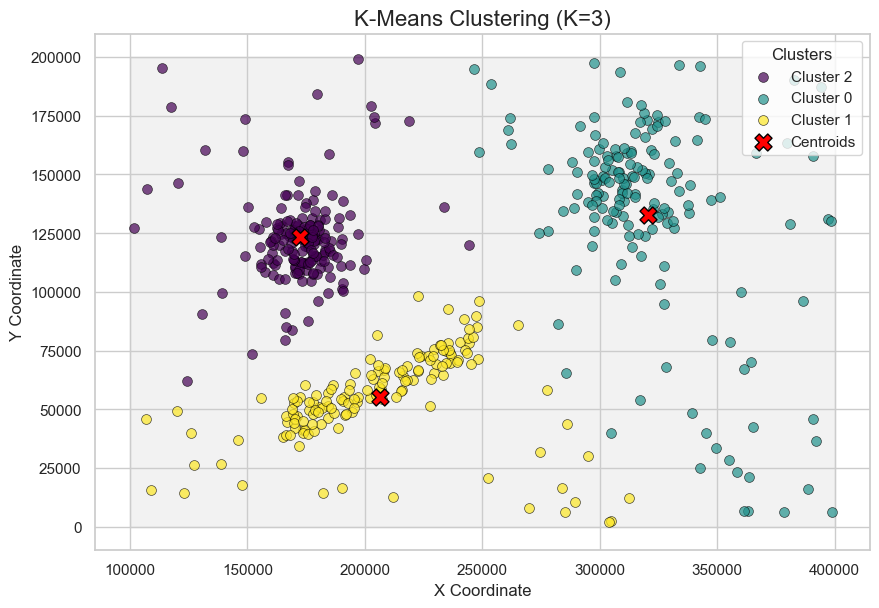


K-Means results for K=4:


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_23292/2565745430.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(palette, len(unique_labels))


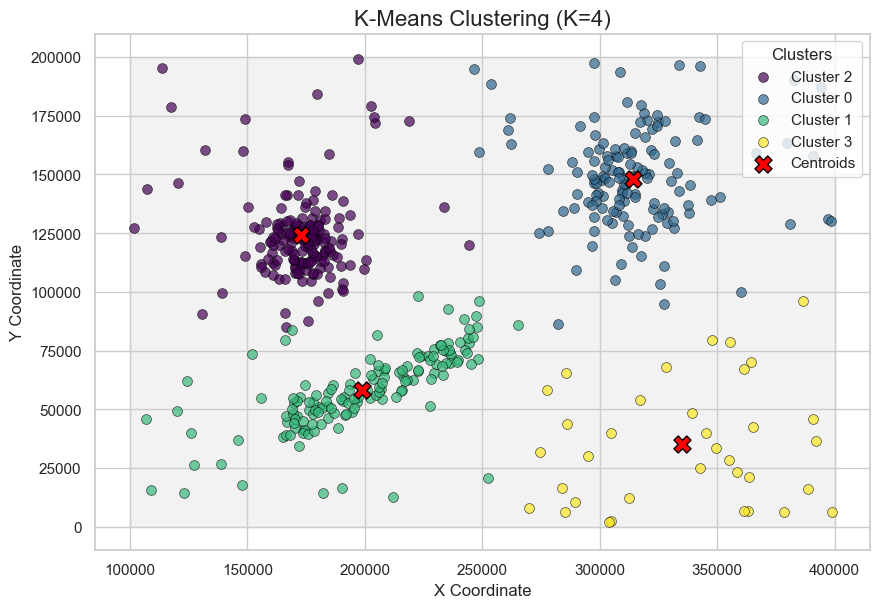

In [4]:
# --- K-Means Implementation ---
# Extract coordinates for K-Means
coords = np.array(list(zip(points_gdf.geometry.x, points_gdf.geometry.y)))

# --- Choosing K (Brief Discussion) ---
# For K-Means, we need to specify K. Let's try a few values or use our knowledge of the synthetic data.
# Our synthetic data has 3 main generated clusters + noise.
# K-Means doesn't have a concept of "noise" like DBSCAN, so it will try to assign all points.
# Let's try K=3 and K=4 to see the effect.

k_values_to_try = [3, 4]  # Based on our synthetic data structure (3 true clusters)
inertia_values = []  # To store inertia for elbow method (optional)

for k_val in k_values_to_try:
    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init=10)  # n_init=10 is a common default
    points_gdf[f'kmeans_labels_k{k_val}'] = kmeans.fit_predict(coords)
    
    # Get centroids for plotting
    centroids_coords = kmeans.cluster_centers_
    centroids_gdf = create_gdf_from_points(centroids_coords[:, 0], centroids_coords[:, 1], REGION_CRS,
                                           attributes={'cluster_id': list(range(k_val))})
    
    print(f"\nK-Means results for K={k_val}:")
    # Plotting
    fig_kmeans, ax_kmeans = plt.subplots(figsize=(10, 8))
    plot_clusters(points_gdf, f'kmeans_labels_k{k_val}', 
                  title=f"K-Means Clustering (K={k_val})", 
                  ax=ax_kmeans, region_boundary_gdf=region_gdf_boundary,
                  centroids_gdf=centroids_gdf)
    plt.show()
    
    inertia_values.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center.

# --- Optional: Elbow Method Plot ---
# if len(k_values_to_try) > 1:  # Only plot if we tried multiple K
#     plt.figure(figsize=(8, 5))
#     plt.plot(k_values_to_try, inertia_values, marker='o', linestyle='--')
#     plt.xlabel("Number of clusters (K)")
#     plt.ylabel("Inertia")
#     plt.title("Elbow Method for Optimal K (Illustrative)")
#     plt.xticks(k_values_to_try)
#     plt.grid(True)
#     plt.show()
#     print("Elbow method: Look for an 'elbow' point where adding more clusters doesn't significantly reduce inertia.")


**K-Means Discussion:**

-   When \( K=3 \), K-Means might group the two spherical clusters correctly and try to fit the elongated cluster into one spherical group, or it might split one of the true clusters. The noise points will be forced into one of these three clusters.
-   When \( K=4 \), it might try to split the elongated cluster or one of the larger spherical clusters, or assign noise points to their own (likely small) cluster.
-   Observe how K-Means struggles with the elongated cluster and how it assigns noise points. It cannot identify noise as a separate category.


## 4. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**Explanation:**

DBSCAN is a density-based clustering algorithm. It groups together points that are closely packed (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions.

**Core Concepts:**
-   **Core Point:** A point is a core point if it has at least `min_samples` points (including itself) within a distance of `eps` (epsilon).
-   **Directly Density-Reachable:** A point `p` is directly density-reachable from a point `q` if `p` is within `q`'s `eps`-neighborhood and `q` is a core point.
-   **Density-Reachable:** A point `p` is density-reachable from `q` if there's a path of points \(p_1, \ldots, p_n\) with \(p_1 = q\) and \(p_n = p\), where each \(p_{i+1}\) is directly density-reachable from \(p_i\).
-   **Cluster:** A cluster is a set of density-connected points. A point `p` is density-connected to `q` if there is a point `o` such that both `p` and `q` are density-reachable from `o`.
-   **Noise:** Points that are not density-reachable from any core point are considered noise or outliers. DBSCAN assigns these points a special cluster label (usually -1).

**Key Parameters:**
-   `eps` (epsilon): The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is a crucial parameter. If too small, most points might be classified as noise. If too large, clusters might merge.
-   `min_samples`: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. Larger values mean denser clusters are required.

**Strengths in Spatial Context:**
-   **Can find arbitrarily shaped clusters:** Unlike K-Means, DBSCAN is not limited to spherical clusters. It can identify elongated, irregular, or non-convex shapes based on density.
-   **Identifies noise/outliers:** This is a significant advantage for real-world spatial data which often contains noise.
-   **Does not require `k` (number of clusters) to be specified:** The number of clusters is determined by the data structure and parameters.

**Weaknesses:**
-   **Parameter sensitivity:** Performance can be quite sensitive to the choice of `eps` and `min_samples`. Finding good values can be challenging.
-   **Struggles with clusters of varying densities:** If clusters have significantly different densities, a single `eps` and `min_samples` setting might not work well for all of them. One cluster might be merged, while another might be split into multiple parts or have its points classified as noise.
-   **Distance metric:** Like K-Means, it typically uses Euclidean distance by default, which might not always be appropriate for spatial data without considering networks or barriers. (Though `metric` can be changed).
-   **Scaling:** For DBSCAN, feature scaling (e.g., using `StandardScaler` if coordinates have very different ranges or if other non-spatial features were included) can be important, though for X,Y coordinates in the same units, it might be less critical than if mixing, say, meters with population counts. Since our X and Y are in meters and have somewhat different ranges (X: 100k–400k, Y: 0–200k), scaling might be beneficial. However, `eps` is an absolute distance, so if we scale, `eps` needs to be chosen for the scaled space. For geographic coordinates, it's often applied directly to the coordinates. We'll try both with and without scaling for our metric coordinates.

**Choosing `eps`:**
A common heuristic for choosing `eps` is to look at the k-distance graph. For a chosen `min_samples` (often \(2 \times \text{dimensionality}\), so for 2D data, `min_samples` around 4–10 is common), calculate the distance to the k-th nearest neighbor for every point. Sort these distances and plot them. The "elbow" or point of maximum curvature in this plot can be a good indicator for `eps`.


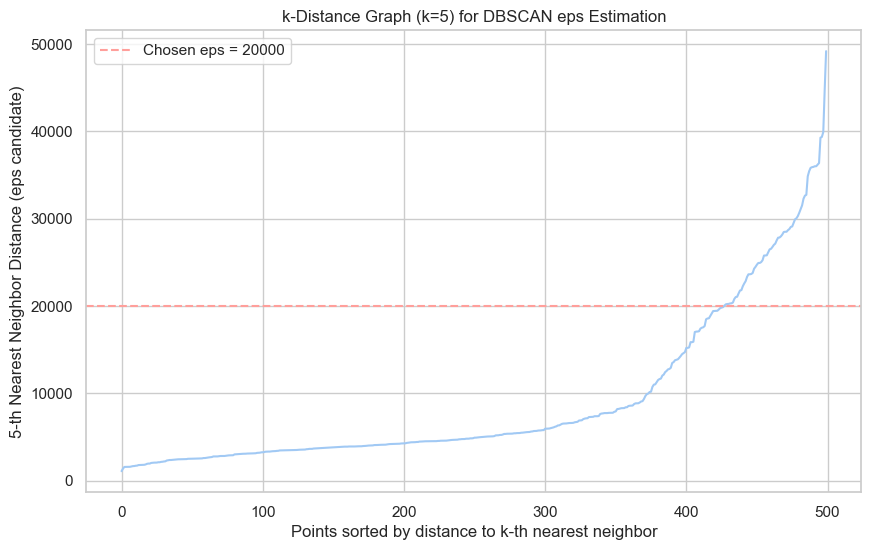

Based on k-distance graph (k=5), a candidate eps could be around 20000 (visual estimate).
Note: The 'elbow' point in the k-distance graph is a heuristic. You might need to experiment.

DBSCAN Results (eps=20000, min_samples=5):
Estimated number of clusters: 7
Estimated number of noise points: 47
Cluster labels found: [-1  0  1  2  3  4  5]


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_23292/2565745430.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(palette, len(unique_labels))
/opt/anaconda3/envs/spatial-ml-env/lib/python3.10/site-packages/geopandas/plotting.py:306: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  collection = ax.scatter(x, y, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


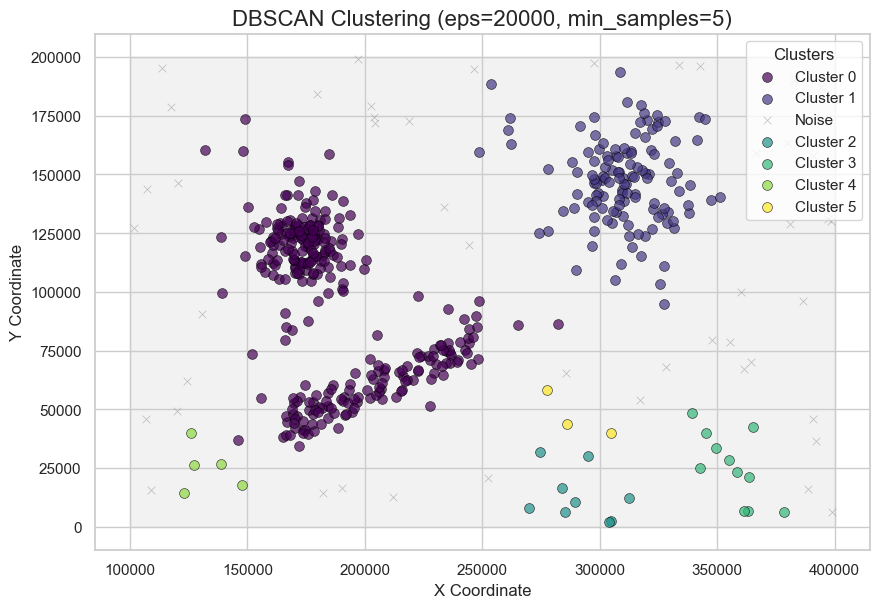

In [7]:
#%%
# --- DBSCAN Implementation ---
# Using the same coordinate array 'coords' from K-Means section

# --- Heuristic for choosing eps ---
# Let's set min_samples. A common starting point is 2 * dimensions. For 2D data, min_samples=4.
# Or a bit higher if we expect denser clusters or want to be more conservative about noise.
min_samples_dbscan = 5

# Calculate distance to k-th nearest neighbor (k = min_samples_dbscan - 1, as NearestNeighbors includes the point itself)
# We use min_samples_dbscan directly for n_neighbors as it's common practice to look at the k=min_samples neighbor.
nn = NearestNeighbors(n_neighbors=min_samples_dbscan)
nn.fit(coords)
distances, indices = nn.kneighbors(coords)

# Sort the distances to the k-th nearest neighbor (the last column in 'distances' array)
kth_distances = np.sort(distances[:, min_samples_dbscan - 1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(kth_distances)
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"{min_samples_dbscan}-th Nearest Neighbor Distance (eps candidate)")
plt.title(f"k-Distance Graph (k={min_samples_dbscan}) for DBSCAN eps Estimation")
plt.grid(True)
# Add a line for a suggested eps based on the "elbow"
# This is visually estimated. For our data, spread1/spread2 were ~10k/15k.
# Let's try an eps around this value or slightly larger.
# From the plot, an elbow might be visible around an eps value.
# For this synthetic data, let's try an eps based on visual inspection of the k-distance plot
# or based on our knowledge of data generation (e.g., `hotspot_spread` was around 10000-15000).
# Let's pick an eps, e.g., 15000 or 20000 based on visual inspection of the k-distance graph.
# The graph should show a sharp increase; the point before that is a good candidate.
# For example, if the elbow is at y=18000 on the k-distance graph:
chosen_eps = 20000  # USER: Adjust this based on your k-distance plot's "elbow"
plt.axhline(y=chosen_eps, color='r', linestyle='--', label=f'Chosen eps = {chosen_eps}')
plt.legend()
plt.show()

print(f"Based on k-distance graph (k={min_samples_dbscan}), a candidate eps could be around {chosen_eps} (visual estimate).")
print(f"Note: The 'elbow' point in the k-distance graph is a heuristic. You might need to experiment.")


# --- Apply DBSCAN ---
# We'll use the coordinates directly without scaling first, as they are in the same unit (meters).
# If we had mixed units or vastly different scales, StandardScaler would be important.
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples_dbscan)
points_gdf['dbscan_labels'] = dbscan.fit_predict(coords)

n_clusters_dbscan = len(set(points_gdf['dbscan_labels'])) - (1 if -1 in points_gdf['dbscan_labels'] else 0)
n_noise_dbscan = list(points_gdf['dbscan_labels']).count(-1)

print(f"\nDBSCAN Results (eps={chosen_eps}, min_samples={min_samples_dbscan}):")
print(f"Estimated number of clusters: {n_clusters_dbscan}")
print(f"Estimated number of noise points: {n_noise_dbscan}")
print(f"Cluster labels found: {np.unique(points_gdf['dbscan_labels'])}")

# Plotting DBSCAN results
fig_dbscan, ax_dbscan = plt.subplots(figsize=(10, 8))
plot_clusters(points_gdf, 'dbscan_labels', 
              title=f"DBSCAN Clustering (eps={chosen_eps}, min_samples={min_samples_dbscan})",
              ax=ax_dbscan, region_boundary_gdf=region_gdf_boundary, show_noise=True)
plt.show()

# --- Optional: DBSCAN with Scaled Data (for comparison if desired) ---
# scaler = StandardScaler()
# coords_scaled = scaler.fit_transform(coords)
# # Re-evaluate eps for scaled data (k-distance plot on scaled data)
# nn_scaled = NearestNeighbors(n_neighbors=min_samples_dbscan).fit(coords_scaled)
# distances_scaled, _ = nn_scaled.kneighbors(coords_scaled)
# kth_distances_scaled = np.sort(distances_scaled[:, min_samples_dbscan - 1], axis=0)
# plt.figure(figsize=(10, 6))
# plt.plot(kth_distances_scaled)
# plt.title(f"k-Distance Graph for SCALED Data (k={min_samples_dbscan})")
# plt.ylabel("Scaled k-th NN Distance")
# plt.show()
# print("Choose eps for scaled data from this new k-distance plot.")
# chosen_eps_scaled = 0.5  # Example: This would need to be determined from the new plot
# dbscan_scaled = DBSCAN(eps=chosen_eps_scaled, min_samples=min_samples_dbscan)
# points_gdf['dbscan_labels_scaled'] = dbscan_scaled.fit_predict(coords_scaled)
# fig_dbscan_s, ax_dbscan_s = plt.subplots(figsize=(10, 8))
# plot_clusters(points_gdf, 'dbscan_labels_scaled', title=f"DBSCAN on Scaled Data (eps={chosen_eps_scaled}, min_samples={min_samples_dbscan})", ax=ax_dbscan_s, region_boundary_gdf=region_gdf_boundary)
# plt.show()



## 5. Comparison and Conclusion

**K-Means vs. DBSCAN on this Synthetic Data:**

-   **Cluster Shape:** K-Means forces clusters to be somewhat spherical due to its centroid-based nature and Euclidean distance. DBSCAN, being density-based, can identify more arbitrary shapes (like our elongated cluster, if parameters are right).
-   **Number of Clusters:** K-Means requires `k` to be pre-specified. DBSCAN determines the number of clusters automatically based on density and its parameters.
-   **Noise Handling:** K-Means assigns every point to a cluster. DBSCAN explicitly identifies and labels noise points, which is often very useful for real-world spatial data.
-   **Parameter Tuning:** K-Means needs `k`. DBSCAN needs `eps` and `min_samples`. Both require some form of tuning or domain knowledge. Choosing DBSCAN parameters can sometimes be less intuitive initially but methods like the k-distance plot help.
-   **Density:** K-Means doesn't explicitly consider density. DBSCAN is fundamentally based on density, making it good for finding areas of high concentration but potentially struggling if true clusters have very different internal densities.

**General Recommendations:**

-   Use **K-Means** when:
    -   You have a good idea of the number of clusters (`k`).
    -   You expect clusters to be roughly spherical and of similar sizes.
    -   Computational efficiency on very large datasets is paramount (though DBSCAN can also be optimized).
    -   You don't need explicit noise detection (or will handle outliers separately).
-   Use **DBSCAN** (or other density-based methods like OPTICS, HDBSCAN) when:
    -   You suspect clusters might have irregular shapes.
    -   You need to identify noise points or outliers.
    -   You don't know the number of clusters beforehand.
    -   You have reason to believe clusters are defined by density rather than just compactness around a center.

**Further Exploration:**

-   **HDBSCAN:** An improvement over DBSCAN that can find clusters of varying densities and is less sensitive to parameter choices (often only needing `min_cluster_size`). It's available in the `hdbscan` library.
-   **OPTICS:** Similar to DBSCAN but can find clusters in data with varying densities more effectively by creating a reachability plot.
-   **Spatial Constraints:** For some applications, you might want to incorporate spatial contiguity constraints into clustering (e.g., using methods based on spatial weights matrices like SKATER in PySAL).
-   **Feature Engineering:** For spatial clustering, sometimes adding features beyond just X,Y coordinates (e.g., local density estimates, proximity to certain landmarks) can improve results if relevant to the problem.

This notebook provides a starting point for understanding and applying these fundamental clustering techniques to spatial point data.
